In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..')
from fastai.vision import *
from audio import *
import matplotlib.pyplot as plt
import math
import wandb
from wandb.fastai import WandbCallback

In [3]:
torch.cuda.is_available()

True

In [4]:
path = Path('data/emotions')
rootname = 'ravdess_audio/Audio_Speech_Actors_01-24'
rootdir = path/rootname

modalities = {
    '01': 'full-AV',
    '02': 'video-only',
    '03': 'audio-only'
}
vocal_channels = {
    '01': 'speech',
    '02': 'song'
}
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
emotional_intensities = {
    '01': 'normal',
    '02': 'strong'
}
statements = {
    '01': 'Kids are talking by the door',
    '02': 'Dogs are sitting by the door'
}
repetitions = {
    '01': '1st repetition',
    '02': '2nd repetition'
}


def get_gender(code):
    tmp = eval(code.lstrip('0'))
    if tmp % 2 == 0:
        return 'female'
    else:
        return 'male'

from collections import defaultdict
genders = defaultdict(lambda: get_gender)

def label_func(fn):
    """
    File naming convention

    Each of the 7356 RAVDESS files has a unique filename. 
    The filename consists of a 7-part numerical identifier
    (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the 
    stimulus characteristics: 

    Filename identifiers 

    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad,
             05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4 

    Video-only (02)
    Speech (01)
    Fearful (06)
    Normal intensity (01)
    Statement "dogs" (02)
    1st Repetition (01)
    12th Actor (12)
    Female, as the actor ID number is even.
    """
    tmp = fn.replace('.wav', '')
    splt = tmp.split('-')
    return {
        'modality': modalities[splt[0]],
        'vocal_channel': vocal_channels[splt[1]],
        'emotion': emotions[splt[2]],
        'emotional_intensity': emotional_intensities[splt[3]],
        'statement': statements[splt[4]],
        'repetition': repetitions[splt[5]],
        'gender': genders[splt[6]](splt[6]),
        'person_id': splt[6]
    }

In [5]:
fp = Path('/course-v3/nbs/dl1/data/emotions/ravdess_audio/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [6]:
data_folder = rootdir

In [7]:
def emotion_label(fp):
    return label_func(fp.name)['emotion']

In [8]:
config = AudioConfig(
    remove_silence="all",
    use_spectro=True,
    duration=4100,
    downmix=True,
    cache=True
    # silence_padding=1000
)
config.cache_dir = Path(
    data_folder/'cache'
)
config.resample_to = 8000
config.sg_cfg = SpectrogramConfig(hop_length=256, n_mels=192)

In [9]:
%%time
audio = AudioList.from_folder(data_folder, config=config) \
    .split_by_rand_pct(.2, seed=4) \
    .label_from_func(func=emotion_label)

KeyError: '0'

In [101]:
data = audio.databunch(bs=64)
data_df = data.to_df()

------------------------------------------------------------
File: data/emotions/ravdess_audio/Audio_Speech_Actors_01-24/cache/sh-a_20-200/0.wav-21c8d55edcfbd862088dbadf2ec4eaf8/0.wav
Total Length: 2.8 seconds
Number of Channels: 1
Label: calm


Channel 0.0 (192x128):


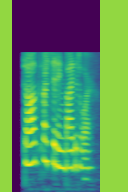

------------------------------------------------------------
File: data/emotions/ravdess_audio/Audio_Speech_Actors_01-24/cache/sh-a_20-200/0.wav-0956937f51a2884b2eb8653c15f995da/0.wav
Total Length: 2.8 seconds
Number of Channels: 1
Label: disgust


Channel 0.0 (192x128):


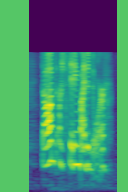

------------------------------------------------------------
File: data/emotions/ravdess_audio/Audio_Speech_Actors_01-24/cache/sh-a_20-200/0.wav-692a858ed19d19720c73990003dd83ae/0.wav
Total Length: 2.4 seconds
Number of Channels: 1
Label: neutral


Channel 0.0 (192x128):


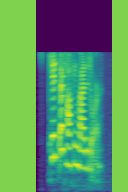

In [102]:
data.show_batch(rows=3, figsize=(7,8))

In [103]:
print('classes:', len(data.classes))
print('samples in training:', len(data.train_ds))
print('samples in validation:', len(data.valid_ds))

classes: 8
samples in training: 1152
samples in validation: 288


In [31]:
learn = audio_learner(data, models.resnet50, metrics=error_rate,callback_fns=WandbCallback)
run = 'run-20200519_092158-fwohnujv'
learn.load('/course-v3/nbs/dl1/wandb/{}/bestmodel'.format(run), strict=False, remove_module=True);
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-3))

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.068930,1.730876,0.690972,00:12
1,2.075647,2.545625,0.767361,00:11
2,2.089419,2.159834,0.736111,00:11
3,2.042358,1.687255,0.708333,00:11
4,1.979413,1.629876,0.670139,00:11


Better model found at epoch 0 with valid_loss value: 1.7308757305145264.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 3 with valid_loss value: 1.6872551441192627.
Better model found at epoch 4 with valid_loss value: 1.6298755407333374.
Loaded best saved model from /course-v3/nbs/dl1/wandb/run-20200519_101512-2gij8qy4/bestmodel.pth


## Cross Validate Model

In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
import shutil
import uuid

In [15]:
import json

In [ ]:
mod = models.resnet50
run = 'run-20200519_092158-fwohnujv'
froze_cycles = 40
unfroze_cycles = 40
n_splits = 3
exp_uuid = str(uuid.uuid1())

spec_config = {
    'sr': 16000,
    'hop_length': 512,
    'power': 1.0,
    'n_mels': 128,
    'fmin': 0.0,
    'fmax': 8000,
    'ref': 1.0, 
    'amin': 1e-05,
    'top_db': 80.0,
}
spec_config['n_fft'] = 20 * spec_config['n_mels']

config = AudioConfig(
    remove_silence="all",
    use_spectro=True,
    duration=4100,
    downmix=True,
    cache=True
    # silence_padding=1000
)
config.cache_dir = Path(
    data_folder/'cache'
)
config.resample_to = 8000
config.sg_cfg = SpectrogramConfig(
    hop_length=spec_config['hop_length'],
    n_mels=spec_config['n_mels'],
    f_min=spec_config['fmin'],
    f_max=spec_config['fmax'],
    n_fft=20*spec_config['n_mels'],
    top_db=spec_config['top_db']
)

start_val = []
froze_val = []
unfroze_val = []

if config.cache_dir.exists():
    shutil.rmtree(config.cache_dir)
audio_list = AudioList.from_folder(path=data_folder, config=config) \
    .split_none() \
    .label_from_func(func=emotion_label)
audio_data = audio_list.databunch(bs=64)
audio_df = audio_data.to_df()
audio_df_idx_on_fp = audio_df.copy()
audio_df_idx_on_fp.index = audio_df_idx_on_fp['x']
doc_config = dict(config)
doc_config['parent'] = run
doc_config['cache_dir'] = str(doc_config['cache_dir'])

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
for train_i, val_i in skf.split(audio_df.index, audio_df['y']):
    fold = audio_data \
        .split_by_idxs(train_i, val_i) \
        .label_from_func(
            func=lambda x: 
            audio_df_idx_on_fp.loc[Path(str(x).replace(str(rootdir), '')[1:])]['y']) \
        .databunch(bs=64)
    wandb.init(
        project=rootname.replace('/', '-').lower(),
        name='run_{}_fr{}_ufr{}_{}of{}_fr'.format(
            exp_uuid, froze_cycles, unfroze_cycles, run_i, n_splits
        ),
        notes=json.dumps(doc_config),
        group=exp_uuid,
        save_code=True,
        tags=[
            'parent_{}'.format(run),
            'sklearn.model_selection.StratifiedKFold',
            str(mod).split(' ')[1],
        ],
        job_type='eval'
    )
    learn = audio_learner(
        data=fold,
        base_arch=mod,
        metrics=error_rate,
        callback_fns=WandbCallback
    )
    learn.load(
        file='/course-v3/nbs/dl1/wandb/{}/bestmodel'.format(run), 
        strict=False,
        remove_module=True
    );
    
    # capture initial error of model
    loss, err = learn.validate()
    start_val.append(err.numpy())
    
    # capture error after frozen tuning of model
    learn.fit_one_cycle(froze_cycles)
    loss, err = learn.validate()
    froze_val.append(err.numpy())
    
    # capture error after full tuning of model
    wandb.init(
        project=rootname.replace('/', '-').lower(),
        name='run_{}_fr{}_ufr{}_{}of{}_ufr'.format(
            exp_uuid, froze_cycles, unfroze_cycles, run_i, n_splits
        ),
        notes=json.dumps(doc_config),
        group=exp_uuid,
        save_code=True,
        tags=[
            'parent_{}'.format(run),
            'sklearn.model_selection.StratifiedKFold',
            str(mod).split(' ')[1],
        ],
        job_type='eval'
    )
    del learn
    learn = audio_learner(
        data=fold,
        base_arch=mod,
        metrics=error_rate,
        callback_fns=WandbCallback
    )
    learn.load(
        file='/course-v3/nbs/dl1/wandb/{}/bestmodel'.format(run), 
        strict=False,
        remove_module=True
    );
    learn.unfreeze()
    learn.fit_one_cycle(unfroze_cycles)
    loss, err = learn.validate()
    unfroze_val.append(err.numpy())
    
    run_i += 1